In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, pickle, multiprocessing, time
from collections import defaultdict
from collections import Counter
import itertools 
import subprocess
import ast
from scipy.stats import spearmanr
from pydeseq2.dds import DeseqDataSet
from pydeseq2.dds import DefaultInference
from pydeseq2.ds import DeseqStats
%matplotlib inline
#os.chdir('/media/sath770/Extreme SSD/Haider Verification SM data')
os.chdir('/media/ivan/Extreme SSD/ABL Verification DMS')

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#In terminal Run these Functions First

#Puts barcode/UMI into read head
umi_tools extract --stdin=sample19_Veri_L1_D0_comb_1.fq --read2-in=sample19_Veri_L1_D0_comb_2.fq --bc-pattern=NNNNNNNNNNNN  --bc-pattern2=NNNNNNNNNNNN -L out.log --stdout=Veri_L1_D0_1.fq --read2-out=Veri_L1_D0_2.fq

#Build refrence index
bowtie2-build -f ABL_kinase.fa ABL

#Align output of UMI_tools to refrence, hard clip 12
bowtie2 -p 15 -q -5 12 -x ABL --1 Veri_L1_D0_1.fq -2 Veri_L1_D0_2.fq  > Veri_L1_D0.txt

#Optional: for local alignment, hard clip 5bp from remained for aligment, then soft clips, I use this to spot check 
bowtie2 -p 15 -q --very-sensitive-local -5 5 -x ABL --1 L1_D0_1.fq -2 L1_D0_2.fq  > aligned_local.txt


In [3]:
common_file_name = list(set([file[:-5] for file in os.listdir()]))
sample_names = ['_'.join(name.split('_')[1:4]) for name in common_file_name]

In [5]:
common_file_name

['sample3_Ivan_L1_D8_CKDL230036383-1A_HGLLGDSX7_L1',
 'sample22_Veri_L2_D14_CKDL230036383-1A_HGLLGDSX7_L1',
 'sample4_Ivan_L2_D8_CKDL230036383-1A_HGLLGDSX7_L1',
 'sample2_Ivan_L2_D6_CKDL230036383-1A_HGLLGDSX7_L1',
 'sample19_Veri_L1_D0_CKDL230036383-1A_HGLLGDSX7_L1',
 'sample21_Veri_L1_D14_CKDL230036383-1A_HGLLGDSX7_L1',
 'sample20_Veri_L2_D0_CKDL230036383-1A_HGLLGDSX7_L1',
 'sample1_Ivan_L1_D6_CKDL230036383-1A_HGLLGDSX7_L1']

In [9]:
for n in range(len(common_file_name)):
    subprocess.call(['umi_tools', 'extract', '--stdin=' + common_file_name[n] + '_1.fq', '--read2-in=' + common_file_name[n] + '_2.fq',
                     '--bc-pattern=NNNNNNNNNNNN', '--bc-pattern2=NNNNNNNNNNNN', '-L', 'out.log', 
                     '--stdout=' + sample_names[n] + '_1.fq' , '--read2-out=' + sample_names[n] + '_2.fq'])

In [18]:
for sample in sample_names:
    subprocess.call(['bowtie2', '-p', '20', '-q', '-5', '12', '-x', 'ABL', '--1',
                     sample + '_1.fq', '--2', sample + '_2.fq', '--output', sample + '.txt'])

21913282 reads; of these:
  21913282 (100.00%) were paired; of these:
    1216586 (5.55%) aligned concordantly 0 times
    20696696 (94.45%) aligned concordantly exactly 1 time
    0 (0.00%) aligned concordantly >1 times
    ----
    1216586 pairs aligned concordantly 0 times; of these:
      33799 (2.78%) aligned discordantly 1 time
    ----
    1182787 pairs aligned 0 times concordantly or discordantly; of these:
      2365574 mates make up the pairs; of these:
        1847166 (78.09%) aligned 0 times
        518408 (21.91%) aligned exactly 1 time
        0 (0.00%) aligned >1 times
95.79% overall alignment rate
38616042 reads; of these:
  38616042 (100.00%) were paired; of these:
    2643583 (6.85%) aligned concordantly 0 times
    35972459 (93.15%) aligned concordantly exactly 1 time
    0 (0.00%) aligned concordantly >1 times
    ----
    2643583 pairs aligned concordantly 0 times; of these:
      149417 (5.65%) aligned discordantly 1 time
    ----
    2494166 pairs aligned 0 times

In [2]:
def read_lines_as_list(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    return [line.split("\t") for line in lines]

def mdz_mismatch_index(mdz):
    mdz_parsed = re.findall(r"[^\W\d_]|\d+|[^\w\d_]+", mdz)
    current_pos = int(mdz_parsed[0])
    previous_char = None
    mismatches = []
    for m in mdz_parsed[1:]:
        if previous_char != '^': #skip deletions
            if m in ['A', 'C', 'T', 'G']:
                mismatches.append([current_pos, m])
        if m.isdigit():
            current_pos = current_pos + int(m) + 1
        previous_char = m
    return(mismatches)

fastq_quality_symbols = "!\"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"
def symbol_to_qscore(symbol):
  return ord(symbol) - 33
qscore_dict = {symbol: symbol_to_qscore(symbol) for symbol in fastq_quality_symbols}

In [3]:
ord('!') - 33

0

In [4]:
def mdz_mismatch_index(mdz):
    mdz_parsed = re.findall(r"[^\W\d_]|\d+|[^\w\d_]+", mdz)
    current_pos = int(mdz_parsed[0])
    previous_char = None
    mismatches = []
    for m in mdz_parsed[1:]:
        if previous_char != '^': #skip deletions
            if m in ['A', 'C', 'T', 'G']:
                mismatches.append([current_pos, m])
        if m.isdigit():
            current_pos = current_pos + int(m) + 1
        previous_char = m
    return(mismatches)

## Updated Alignment Length to match 12 bp 5' cut off

In [8]:
###IF CHANGE CLIPPING, NEED TO ADJUST Alignment Length
def read_to_UMImismatch_perRead(read):
    aln = read.split("\t")
    mismatches_qual = []
    if aln[5]!='*':
        UMI = aln[0].split('_')[1] #UMI
        POS = int(aln[3]) #1-index position of mismatch
        TLEN= int(aln[8]) #read length direction
        seq = aln[9] #alighned sequence
        mdz = aln[17][5:] #mismatch info tag
        NM = aln[16][5:] #number of mismatches in alighnment
        qual = aln[10] #quality of sequence
        cigar = aln[5] #mismatch info tag
        if cigar == '126M': #no deletions or inertions
            if mdz == '126':
                mismatches_qual.append([UMI,TLEN, [[0, 'WT']]])
            if mdz != '126': #not WT perfect alinment
                mismatch_mdz_read = []
                for i,m in mdz_mismatch_index(mdz):
                    if (ord(qual[i])-33) > 30: #quality score cutoff
                        mismatch_mdz_read.append([i+POS, seq[i]])
                mismatches_qual.append([UMI, TLEN, mismatch_mdz_read])  #tuple mismatch info
#                if len(mismatch_mdz_read) < 1:
#                    mismatches_qual.append([UMI, TLEN, [[0, 'WT']]])  #tuple mismatch info 
    return mismatches_qual

In [9]:
#Loops through file to pickout mutations in each read
#Need to loop through alignment file bc its too big process in memeory at once
#Uses multiprocessing to process to speed up
for sample in ['Veri_L1_D0',]:
    loops = 0
    with open(sample + '.txt', 'r') as file:
        start = time.time()
        while True:
            multi_thread_UMI_mismatch = []
            head = file.readlines(3000000000) #3000000000
            if loops == 0:
                head = head[3:]
            if __name__ == '__main__':
                pool = multiprocessing.Pool(22)
                jobs = []
                for read in head:
                    jobs.append(pool.apply_async(read_to_UMImismatch_perRead, (read, )))
                for job in jobs:
                    UMI_mismatches = job.get()
                    if UMI_mismatches!=[]: #if no alighment
                        multi_thread_UMI_mismatch.append(UMI_mismatches[0])
                print('storing job list')
                with open(sample+'_'+str(loops)+'.pkl', 'wb') as f:
                    pickle.dump(multi_thread_UMI_mismatch, f)
                print((sample + ' Loop ' + str((loops+1))))
                print(time.time() - start)
                loops += 1
            if loops == 5: #do not need more this many reads for anlysis
                break

storing job list
Veri_L1_D0 Loop 1
431.44015550613403
storing job list
Veri_L1_D0 Loop 2
871.4746541976929
storing job list
Veri_L1_D0 Loop 3
1154.308465719223
storing job list
Veri_L1_D0 Loop 4
1170.2214570045471
storing job list
Veri_L1_D0 Loop 5
1173.6153478622437


Process ForkPoolWorker-105:
Process ForkPoolWorker-110:
Process ForkPoolWorker-107:
Process ForkPoolWorker-95:
Process ForkPoolWorker-100:
Process ForkPoolWorker-102:
Process ForkPoolWorker-94:
Process ForkPoolWorker-93:
Process ForkPoolWorker-108:
Process ForkPoolWorker-96:
Process ForkPoolWorker-103:
Process ForkPoolWorker-97:
Process ForkPoolWorker-106:
Process ForkPoolWorker-104:
Process ForkPoolWorker-101:
Process ForkPoolWorker-99:
Process ForkPoolWorker-109:
Process ForkPoolWorker-92:
Process ForkPoolWorker-91:
Process ForkPoolWorker-89:
Process ForkPoolWorker-90:
Process ForkPoolWorker-98:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback 

In [45]:
## UNDER Construction
#Can use memory map to seqentually read data convert bytes to strings, and process reads
import mmap
with open("aligned.txt", "r+") as f:
    start = time.time()
    # memory-map the file, size 0 means whole file
    mm = mmap.mmap(f.fileno(), 0)
    head = mm[:].splitlines()
    for read in head:
        jobs.append(pool.apply_async(read_to_UMImismatch_perRead, (read.decode("utf-8"), )))
    for job in jobs:
        UMI_mismatches = job.get()
        if UMI_mismatches!=[]: #if no alighment
            multi_thread_UMI_mismatch.append(UMI_mismatches[0])
    print(time.time() - start)
    mm.close()

IndexError: list index out of range

## Determin Most Frequent UMIs and remove duplicates with 1 mismatch

In [3]:
#Change Samples As Needed
sample_names = ['Ivan_L1_D8',
 'Veri_L2_D14',
 'Ivan_L2_D8',
 'Ivan_L2_D6',
 'Veri_L1_D0',
 'Veri_L1_D14',
 'Veri_L2_D0',
 'Ivan_L1_D6']

In [28]:
#Put all UMIS into one list
for sample in sample_names:
    sample_UMI_list = []
    for loop in range(5):
        with open(sample+'_'+str(loop)+'.pkl', 'rb') as f:
            CL_UMI_mismatch = pickle.load(f)
        for umi, read, mismatch in CL_UMI_mismatch:
                sample_UMI_list.append(umi)
        dedup_sample_UMI_list = list(set(sample_UMI_list))
        UMI_Counter = Counter(sample_UMI_list)
        with open(sample + '_UMIs.fasta', 'w') as f:
            for umi in dedup_sample_UMI_list:
                f.write(('>' + umi + str(UMI_Counter[umi]) + '\n'))
                f.write((umi + '\n'))

In [27]:
sample_names = ['Veri_L1_D0',]

In [29]:
#Build Refrense for all samples
for sample in sample_names:
    subprocess.call(['bowtie-build', sample + '_UMIs.fasta', sample + '_ref'])

Settings:
  Output files: "Veri_L1_D0_ref.*.ebwt"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 5 (one in 32)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  Veri_L1_D0_UMIs.fasta
Reading reference sizes
  Time reading reference sizes: 00:00:02
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:02
bmax according to bmaxDivN setting: 34974036
Using parameters --bmax 26230527 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 26230527 --dcv 1024
Constructing suffix-array element 

In [30]:
#Align UMIs to themselves
for sample in sample_names:
    subprocess.call(['bowtie', '-a', '-n', '1', '-p', '20', '-f', '-x',  sample + '_ref' , sample + '_UMIs.fasta', sample +'_UMI_aln.txt' ])

# reads processed: 5829273
# reads with at least one alignment: 5825601 (99.94%)
# reads that failed to align: 3672 (0.06%)
Reported 6178891 alignments


In [ ]:
#in terminal
bowtie-build UMI.fasta UMI
bowtie -a -n 1 -p 20 -f UMI UMI.fasta > results.txt
#had to change to allow only 1 error because 2 errors resulted in UMI collisions

In [4]:
sample_names = ['Veri_L1_D0', 'Veri_L2_D0', 'Ivan_L1_D6',  'Ivan_L2_D6',
                'Ivan_L1_D8',  'Ivan_L2_D8', 'Veri_L1_D14', 'Veri_L2_D14']

In [34]:
sample_unique_umi_dict = dict()

for sample in sample_names:
    UMI_bowtie = []
    #open aligment
    with open( sample +'_UMI_aln.txt') as f:
        for line in f:
            alnm = line.split('\t')
            UMI_bowtie.append(alnm)
    print('Opened ' + sample)
    #group UMIs based on if they match by duplicates or not   
    UMI_bowtie_LL = set()
    prev_aln = None
    temp_group_list = []
    
    for aln in UMI_bowtie:
        if prev_aln == aln[0]:
            temp_group_list.append(aln[2])
            prev_aln = aln[0]
        if prev_aln != aln[0]:
            UMI_bowtie_LL.add(frozenset(temp_group_list))
            temp_group_list = [aln[2]]
            prev_aln = aln[0]
    print('Found uniuqe UMIs and UMI groups')
    #identify UMIs with greatest occurance in each group
    unique_UMIs = []
    for elm in UMI_bowtie_LL:
        if len(elm) == 1:
            for i in elm:
                unique_UMIs.append(i[:24])
        UMI_group = []
        UMI_group_occurances = []
        if len(elm) > 1:
            UMI_group = [umi[:24] for umi in elm]
            UMI_group_occurances = [int(umi[24:]) for umi in elm]
            for i in UMI_group[UMI_group_occurances.index(max(UMI_group_occurances))]:
                unique_UMIs.append(i[:24])      
    #save deduplicate list of unique UMIs
    dedup_unique_UMIs = list(set(unique_UMIs))
    sample_unique_umi_dict[sample] = dedup_unique_UMIs
    print([sample, len(dedup_unique_UMIs)])

Opened Veri_L1_D0
Found uniuqe UMIs and UMI groups
['Veri_L1_D0', 5511558]
Opened Veri_L2_D0
Found uniuqe UMIs and UMI groups
['Veri_L2_D0', 10965778]
Opened Ivan_L1_D6
Found uniuqe UMIs and UMI groups
['Ivan_L1_D6', 11199251]
Opened Ivan_L2_D6
Found uniuqe UMIs and UMI groups
['Ivan_L2_D6', 14124878]
Opened Ivan_L1_D8
Found uniuqe UMIs and UMI groups
['Ivan_L1_D8', 13452680]
Opened Ivan_L2_D8
Found uniuqe UMIs and UMI groups
['Ivan_L2_D8', 13542873]
Opened Veri_L1_D14
Found uniuqe UMIs and UMI groups
['Veri_L1_D14', 11139497]
Opened Veri_L2_D14
Found uniuqe UMIs and UMI groups
['Veri_L2_D14', 9770701]


In [35]:
#save good UMIs for subsequent analysis
with open('Most_Frequent_UMIs_per_Sample.pkl', 'wb') as f:
    pickle.dump(sample_unique_umi_dict, f)

### Count Mutations for each UMI

In [5]:
#change names as needed
sample_names = ['Veri_L1_D0', 'Veri_L2_D0', 'Ivan_L1_D6',  'Ivan_L2_D6',
                'Ivan_L1_D8',  'Ivan_L2_D8', 'Veri_L1_D14', 'Veri_L2_D14']

In [2]:
#load good UMIs
with open('Most_Frequent_UMIs_per_Sample.pkl', 'rb') as f:
    sample_unique_umi_dict = pickle.load(f)

In [50]:
#OLD Version
for sample in sample_names:
    #make all umi dict of all mismatches
    UMI_mis_dict = defaultdict(list)
    for loop in range(5):
        with open(sample+'_'+str(loop)+'.pkl', 'rb') as f:
            CL_UMI_mismatch = pickle.load(f)
        for umi, read, mismatch in CL_UMI_mismatch:
                UMI_mis_dict[umi].append([read, mismatch])
    print('Load ' + sample + ' mismatchs')
    #consensus per good umi for all sample
    mismatch_per_good_umi = []
    for umi in sample_unique_umi_dict[sample]:
        umi_mis_pos = []
        umi_mis_neg = []
        for read, mismatch in UMI_mis_dict[umi]:
            if read > 0:
                umi_mis_pos.append(str(mismatch))
            if read < 0:
                umi_mis_neg.append(str(mismatch))
        UMI_consensus = [] #string of list of muts
        for mut in list(set(umi_mis_pos)):
            if umi_mis_pos.count(mut) > 0.8 * len(umi_mis_pos):
                UMI_consensus.append(mut)
        for mut in list(set(umi_mis_neg)):
            if umi_mis_neg.count(mut) > 0.8 * len(umi_mis_pos):
                UMI_consensus.append(mut)
        UMI_consensus_dedup = [] #list mut
        for mut in list(set(UMI_consensus)):
            if mut != '[]':
                UMI_consensus_dedup.append(ast.literal_eval(mut))
        mismatch_per_good_umi.append(UMI_consensus_dedup)
    print('Save ' + sample + ' consensus mutations ' + str(len(mismatch_per_good_umi)))
    with open(sample + '_consensus_per_umi.pkl', 'wb') as f:
        pickle.dump(mismatch_per_good_umi, f)

Load Ivan_L1_D8 mismatch
Save Ivan_L1_D8 consensus mutations 13452680
Load Veri_L2_D14 mismatch
Save Veri_L2_D14 consensus mutations 9770701
Load Ivan_L2_D8 mismatch
Save Ivan_L2_D8 consensus mutations 13542873
Load Ivan_L2_D6 mismatch
Save Ivan_L2_D6 consensus mutations 14124878
Load Veri_L1_D0 mismatch
Save Veri_L1_D0 consensus mutations 4264777
Load Veri_L1_D14 mismatch
Save Veri_L1_D14 consensus mutations 11139497
Load Veri_L2_D0 mismatch
Save Veri_L2_D0 consensus mutations 10965778
Load Ivan_L1_D6 mismatch
Save Ivan_L1_D6 consensus mutations 11199251


In [6]:
#VERSION 2 only make with at least 4 reads (count forward and reverse reads)
for sample in sample_names:
    #make all umi dict of all mismatches
    UMI_mis_dict = defaultdict(list)
    for loop in range(5):
        with open(sample+'_'+str(loop)+'.pkl', 'rb') as f:
            CL_UMI_mismatch = pickle.load(f)
        for umi, read, mismatch in CL_UMI_mismatch:
                UMI_mis_dict[umi].append([read, mismatch])
    print('Load ' + sample + ' mismatchs')
    #consensus per good umi for all sample with at least 3 froward and 3 reverse
    mismatch_per_good_umi = []
    for umi in sample_unique_umi_dict[sample]:
        reads_per_umi = UMI_mis_dict[umi]
        if len(reads_per_umi) > 4 : #Require at least 4 reads per UMI 
            umi_mis_pos = []
            umi_mis_neg = []
            for read, mismatch in reads_per_umi:
                if read > 0:
                    umi_mis_pos.append(str(mismatch))
                if read < 0:
                    umi_mis_neg.append(str(mismatch))
            UMI_consensus = [] #string of list of muts
            for mut in list(set(umi_mis_pos)):
                if umi_mis_pos.count(mut) > 0.8 * len(umi_mis_pos):
                    UMI_consensus.append(mut)
            for mut in list(set(umi_mis_neg)):
                if umi_mis_neg.count(mut) > 0.8 * len(umi_mis_pos):
                    UMI_consensus.append(mut)
            UMI_consensus_dedup = [] #list mut
            for mut in list(set(UMI_consensus)):
                if mut != '[]':
                    UMI_consensus_dedup.append(ast.literal_eval(mut))
            mismatch_per_good_umi.append(UMI_consensus_dedup)
        if len(reads_per_umi) < 4:
            continue
    print('Save ' + sample + ' consensus mutations ' + str(len(mismatch_per_good_umi)))
    with open(sample + '_consensus_per_umi_w3reads.pkl', 'wb') as f:
        pickle.dump(mismatch_per_good_umi, f)

Load Veri_L1_D0 mismatchs
Save Veri_L1_D0 consensus mutations 296503
Load Veri_L2_D0 mismatchs
Save Veri_L2_D0 consensus mutations 328882
Load Ivan_L1_D6 mismatchs
Save Ivan_L1_D6 consensus mutations 164959
Load Ivan_L2_D6 mismatchs
Save Ivan_L2_D6 consensus mutations 208369
Load Ivan_L1_D8 mismatchs
Save Ivan_L1_D8 consensus mutations 309411
Load Ivan_L2_D8 mismatchs
Save Ivan_L2_D8 consensus mutations 273207
Load Veri_L1_D14 mismatchs
Save Veri_L1_D14 consensus mutations 441484
Load Veri_L2_D14 mismatchs
Save Veri_L2_D14 consensus mutations 1024611


### Count Mutations per Sample

In [88]:
All_sample_mismatch_count = pd.DataFrame(columns=[['Mismatch', 'Count', 'Sample']])

for sample in sample_names:
    with open(sample + '_consensus_per_umi_w3reads.pkl', 'rb') as f:
        mismatch_per_good_umi = pickle.load(f)
    WT_purged_mismatch_string = []
    for mis in mismatch_per_good_umi:
        if mis != []: #if there is no conesus or mut Q is low, then ignored
            if mis == [[[0, 'WT']]]: # if WT
                WT_purged_mismatch_string.append(str([]))
            if mis != [[[0, 'WT']]]:
                if [[0, 'WT']] in mis:
                    mis.remove([[0,'WT']])
                if len(mis) == 1:
                    WT_purged_mismatch_string.append(str(mis[0]))
                if len(mis) > 1:
                    unpacked = []
                    for read in mis:
                        if len(read) == 1:
                            if read[0] not in unpacked:
                                unpacked.append(read[0])
                        if len(read) != 1:
                            for multi_mis in read:
                                if multi_mis not in unpacked:
                                    unpacked.append(multi_mis)
                    WT_purged_mismatch_string.append(str(sorted(unpacked)))
    sample_mismatch_count_DF = pd.DataFrame.from_dict(Counter(WT_purged_mismatch_string), orient='index').reset_index()
    sample_mismatch_count_DF.columns = ['Mismatch', 'Count']
    sample_mismatch_count_DF['Sample'] = sample
    print(sample + ' collapsed to ' + str(len(sample_mismatch_count_DF)))
    All_sample_mismatch_count = pd.concat([All_sample_mismatch_count, sample_mismatch_count_DF])

Veri_L1_D0 collapsed to 2380
Veri_L2_D0 collapsed to 3121
Ivan_L1_D6 collapsed to 2299
Ivan_L2_D6 collapsed to 2122
Ivan_L1_D8 collapsed to 2006
Ivan_L2_D8 collapsed to 2434
Veri_L1_D14 collapsed to 3287
Veri_L2_D14 collapsed to 2274


In [90]:
All_mismatch_PV = pd.pivot_table(All_sample_mismatch_count, index='Mismatch', values='Count', columns='Sample').fillna(0).sort_values('Veri_L2_D0',ascending=False)

In [108]:
All_mismatch_PV.to_csv('HaiderVerification_All_Sample_count.csv')

In [3]:
#if restarting notebook
All_mismatch_PV = pd.read_csv('HaiderVerification_All_Sample_count.csv')
All_mismatch_PV = All_mismatch_PV.set_index('Mismatch')

## Determine AA effect of mutations

In [4]:
abl = 'cccactgtctatggtgtgtcccccaactacgacaagtgggagatggaacgcacggacatcaccatgaagcacaagctgggcgggggccagtacgggGAGgtgtacgagggcgtgtggaagaaatacagcctgacggtggccgtgaagaccttgaaggaggacaccatggaggtggaagagttcttgaaagaagctgcagtcatgaaagagatcaaacaccctaacctggtgcagctccttggggtctgcacccgggagcccccgttctatatcatcACTgagttcatgacctacgggaacctcctggactacctgagggagtgcaaccggcaggaggtgaacgccgtggtgctgctgtacatggccactcagatctcgtcagccatggagtacctggagaagaaaaacttcatccacagagatcttgctgcccgaaactgcctggtaggggagaaccacttggtgaaggtagctgattttggcctgagcaggttgatgacaggggacacctacacagcccatgctggagccaagttccccatcaaatggactgcacccgagagcctggcctacaacaagttctccatcaagtccgacgtctgggcatttggagtattgctttgggaaattgctacctatggcatgtccccttacccgggaattgacctgtcccaggtgtatgagctgctagagaaggactaccgcatggagcgcccagaaggctgcccagagaaggtctatgaactcatgcgagcatgttggcagtggaatccctctgaccggccctcctttgctgaaatccaccaagcctttgaaacaatgttccaggaatccagtatctcagacgaagtggaaaaggagctggggaaa'

In [5]:
abl = abl.lower()

In [6]:
def RevComplment(s): #Case-senstive reverse complmnentarty conversion
    comp = []
    for i in s[::-1]:
        if i == 'a':
            comp.append('t')
        if i == 'A':
            comp.append('T')
        if i == 't':
            comp.append('a')
        if i == 'T':
            comp.append('A')
        if i == 'c':
            comp.append('g')
        if i == 'C':
            comp.append('G')
        if i == 'g':
            comp.append('c')
        if i == 'G':
            comp.append('C')
    return ''.join(comp)


Codons = []
with open("CodonTable.txt") as File:
    for line in File:
        line = line.split()
        Codons.append(line)

In [7]:
#Codon Dictionary recognizes upper and lower case inputs to Codon Letters
CodonDict = {}
for cod in Codons[1:]:
    CodonDict[cod[1]] = cod[3]
    CodonDict[cod[0]] = cod[3]

In [8]:
#as a function
def mut_to_AA_effct2(mut):
    mut_set = ast.literal_eval(mut)
    AA_muted = [] #AA position that are mutated
    mut_nuc_info = [] #AA position, nuc num, nuc id
    for nuc_num, nuc_id in mut_set:
        if ((nuc_num-1)//3) not in AA_muted:
            AA_muted.append((nuc_num-1)//3) #0-indexed AA position
        mut_nuc_info.append([(nuc_num-1)//3, (nuc_num-1), nuc_id]) #0-indexed AA, nuc positions
    
    All_mut_effcts = []
    All_nuc_effects = []
    for AA_mut in AA_muted: #check every AA that is mutated
        temp_nuc_muts = [] #hold all mutations for the same AA position
        for AA_pos, nuc_num, nuc_id in mut_nuc_info:
            if AA_pos == AA_mut:
                temp_nuc_muts.append([AA_pos, nuc_num, nuc_id])
        ABL_WT_codon = abl[AA_mut*3:(AA_mut+1)*3]
        ABL_WT_AA = CodonDict[ABL_WT_codon]
        ABL_mut_codon = ABL_WT_codon #start mutagenesis with WT codon
        for AA_pos, nuc_num, nuc_id in temp_nuc_muts:
            ABL_mut_codon = list(ABL_mut_codon) #convert codon to list
            ABL_mut_codon[((nuc_num)%3)] = nuc_id #change nuc 
            ABL_mut_codon = ''.join(ABL_mut_codon) #convert back to codon
            ABL_mut_AA = CodonDict[ABL_mut_codon.upper()] #get AA of new codon
        All_nuc_effects.append([ABL_WT_codon[((nuc_num)%3)].upper(), nuc_id])
        All_mut_effcts.append([ABL_WT_codon, ABL_mut_codon, ABL_WT_AA, AA_pos+223, ABL_mut_AA]) #1-index AA position
    return([All_nuc_effects, All_mut_effcts])

In [9]:
all_mismatches = All_mismatch_PV.index.values.tolist()
Mut_Effects = []
ABE_Activity = []
for mismatch in all_mismatches:
    mismatch_predictions = mut_to_AA_effct2(mismatch)
    Mut_Effects.append(mismatch_predictions[1])
    temp_nuc_muts = []
    for nuc_mut in mismatch_predictions[0]:
        #in case of single edits
        if nuc_mut == ['A', 'G']:
            temp_nuc_muts.append('A > G')
        if nuc_mut == ['T', 'C']:
            temp_nuc_muts.append('A > G')
        if nuc_mut != ['A', 'G']:
            if nuc_mut != ['T', 'C']:
                temp_nuc_muts.append('Other')
    nuc_mut_summary = list(set(temp_nuc_muts))
    if len(nuc_mut_summary) == 0:
        ABE_Activity.append('WT')
    if len(nuc_mut_summary) == 1:
        ABE_Activity.append(nuc_mut_summary[0])
    if len(nuc_mut_summary) > 1:
        ABE_Activity.append('Other')

In [10]:
len(Mut_Effects) == len(ABE_Activity)

True

In [11]:
sample_names = ['Veri_L1_D0', 'Veri_L2_D0', 'Ivan_L1_D6',  'Ivan_L2_D6',
                'Ivan_L1_D8',  'Ivan_L2_D8', 'Veri_L1_D14', 'Veri_L2_D14']

In [12]:
All_mismatch_PV['Mutation_Effect'] = Mut_Effects
All_mismatch_PV['ABE_Activity'] = ABE_Activity

In [13]:
count = All_mismatch_PV[sample_names].T
#minimum of 20 observations
count = count.loc[: ,((count > 3).sum(axis=0) > 7)] 
meta = pd.DataFrame(sample_names, columns=['sample'])
meta['condition'] = meta['sample'].str.split('_', expand=True)[2]
meta = meta.set_index('sample')

In [14]:
count

Mismatch,[],"[[307, 'T']]","[[77, 'C']]","[[89, 'G']]","[[89, 'G'], [92, 'G']]","[[143, 'C']]","[[181, 'C']]","[[155, 'G']]","[[163, 'G'], [166, 'G']]","[[154, 'G'], [155, 'G']]",...,"[[74, 'G']]","[[160, 'T']]","[[252, 'A']]","[[111, 'A']]","[[295, 'T']]","[[176, 'G'], [177, 'G']]","[[118, 'G']]","[[173, 'G']]","[[130, 'A']]","[[140, 'A']]"
Veri_L1_D0,194393.0,6875.0,3578.0,1233.0,2018.0,1292.0,655.0,468.0,923.0,861.0,...,8.0,8.0,8.0,4.0,7.0,5.0,4.0,6.0,5.0,601.0
Veri_L2_D0,217978.0,4590.0,3876.0,1819.0,1798.0,1719.0,1540.0,1428.0,723.0,703.0,...,6.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0
Ivan_L1_D6,121186.0,1265.0,283.0,91.0,182.0,66.0,247.0,793.0,172.0,157.0,...,28.0,22.0,6.0,10.0,26.0,26.0,6.0,8.0,7.0,8.0
Ivan_L2_D6,156547.0,2091.0,259.0,246.0,116.0,52.0,152.0,602.0,132.0,73.0,...,25.0,16.0,9.0,13.0,29.0,33.0,14.0,5.0,13.0,6.0
Ivan_L1_D8,236712.0,2872.0,196.0,108.0,91.0,69.0,127.0,609.0,184.0,160.0,...,18.0,32.0,4.0,8.0,30.0,10.0,6.0,12.0,8.0,7.0
Ivan_L2_D8,204371.0,3217.0,187.0,128.0,33.0,43.0,163.0,776.0,71.0,43.0,...,16.0,28.0,9.0,5.0,29.0,36.0,5.0,8.0,31.0,6.0
Veri_L1_D14,329546.0,6275.0,263.0,106.0,108.0,54.0,117.0,1639.0,133.0,89.0,...,20.0,18.0,26.0,35.0,15.0,79.0,11.0,9.0,18.0,35.0
Veri_L2_D14,764847.0,24051.0,153.0,210.0,9.0,27.0,93.0,2097.0,101.0,141.0,...,9.0,19.0,10.0,5.0,12.0,93.0,7.0,16.0,1475.0,4.0


In [15]:
inference = DefaultInference(n_cpus=20)
dds = DeseqDataSet(
    counts=count,
    metadata=meta,
    design_factors="condition",
    refit_cooks=True,
    n_cpus=20)
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a s

In [16]:
DESeq2_Normed_Counts = pd.DataFrame(dds.layers['normed_counts'], index=count.index, columns=count.columns).T
DESeq2_Normed_Freq = DESeq2_Normed_Counts.div(DESeq2_Normed_Counts.sum(axis=0), axis=1)
DESeq2_Normed_Freq.to_csv('DESeq2_Normed_Freq_ABL_Verification_Screen.csv')

In [17]:
DESeq2_Normed_Freq['D0'] = DESeq2_Normed_Freq[['Veri_L1_D0', 'Veri_L2_D0']].mean(axis=1)
DESeq2_Normed_Freq['D6_Rep1'] = np.log2(DESeq2_Normed_Freq['Ivan_L1_D6']/DESeq2_Normed_Freq['D0'])
DESeq2_Normed_Freq['D6_Rep2'] = np.log2(DESeq2_Normed_Freq['Ivan_L2_D6']/DESeq2_Normed_Freq['D0'])
DESeq2_Normed_Freq['D13_Rep1'] = np.log2(DESeq2_Normed_Freq['Veri_L1_D14']/DESeq2_Normed_Freq['D0'])
DESeq2_Normed_Freq['D13_Rep2'] = np.log2(DESeq2_Normed_Freq['Veri_L2_D14']/DESeq2_Normed_Freq['D0'])

In [18]:
DESeq2_Normed_Freq

,Veri_L1_D0,Veri_L2_D0,Ivan_L1_D6,Ivan_L2_D6,Ivan_L1_D8,Ivan_L2_D8,Veri_L1_D14,Veri_L2_D14,D0,D6_Rep1,D6_Rep2,D13_Rep1,D13_Rep2
Mismatch,,,,,,,,,,,,,
[],0.866468,0.872928,0.875938,0.907708,0.932605,0.917437,0.921359,0.941569,0.869698,0.010314,0.061714,0.083248,0.114552
"[[307, 'T']]",0.030644,0.018381,0.009143,0.012124,0.011315,0.014441,0.017544,0.029608,0.024513,-1.422713,-1.015630,-0.482557,0.272465
"[[77, 'C']]",0.015948,0.015522,0.002046,0.001502,0.000772,0.000839,0.000735,0.000188,0.015735,-2.943439,-3.389262,-4.419501,-6.384419
"[[89, 'G']]",0.005496,0.007284,0.000658,0.001426,0.000426,0.000575,0.000296,0.000259,0.006390,-3.280238,-2.163490,-4.430434,-4.627496
"[[89, 'G'], [92, 'G']]",0.008995,0.007200,0.001316,0.000673,0.000359,0.000148,0.000302,0.000011,0.008098,-2.621880,-3.589666,-4.745110,-9.513459
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[[176, 'G'], [177, 'G']]",0.000022,0.000020,0.000188,0.000191,0.000039,0.000162,0.000221,0.000114,0.000021,3.151125,3.177107,3.384143,2.436134
"[[118, 'G']]",0.000018,0.000020,0.000043,0.000081,0.000024,0.000022,0.000031,0.000009,0.000019,1.196251,2.100671,0.700397,-1.135066
"[[173, 'G']]",0.000027,0.000016,0.000058,0.000029,0.000047,0.000036,0.000025,0.000020,0.000021,1.435333,0.439288,0.234935,-0.118377


In [19]:
all_mismatches = DESeq2_Normed_Freq.index.values.tolist()
Mut_Effects = []
ABE_Activity = []
Nuc_edits = []
for mismatch in all_mismatches:
    Nuc_edits.append(len(ast.literal_eval(mismatch)))
    mismatch_predictions = mut_to_AA_effct2(mismatch)
    Mut_Effects.append(mismatch_predictions[1])
    temp_nuc_muts = []
    for nuc_mut in mismatch_predictions[0]:
        if nuc_mut == ['A', 'G']:
            #temp_nuc_muts.append('ABE_positive')
            temp_nuc_muts.append('A > G')
        if nuc_mut == ['T', 'C']:
            #temp_nuc_muts.append('ABE_negative')
            temp_nuc_muts.append('A > G')
        elif nuc_mut != ['A', 'G']:
            if nuc_mut != ['T', 'C']:
                temp_nuc_muts.append('Other')
    nuc_mut_summary = list(set(temp_nuc_muts))
    if len(nuc_mut_summary) == 0:
        ABE_Activity.append('WT')
    if len(nuc_mut_summary) == 1:
        ABE_Activity.append(nuc_mut_summary[0])
    if len(nuc_mut_summary) > 1:
        ABE_Activity.append('Other')

In [20]:
DESeq2_Normed_Freq['Mutation_Effect'] = Mut_Effects
DESeq2_Normed_Freq['ABE_Activity'] = ABE_Activity

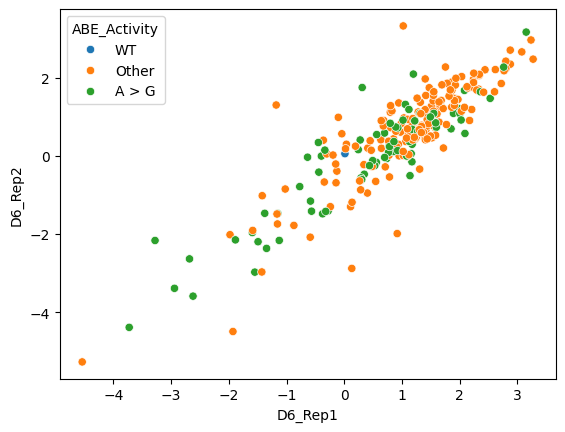

In [21]:
Veri_Muts = sns.scatterplot(x='D6_Rep1', y='D6_Rep2', hue='ABE_Activity',data=DESeq2_Normed_Freq)

In [22]:
spearmanr(DESeq2_Normed_Freq['D6_Rep1'], DESeq2_Normed_Freq['D6_Rep2'])

SignificanceResult(statistic=0.8453213367858347, pvalue=1.4535925705326476e-73)

In [23]:
D6 = DeseqStats(dds, contrast=["condition", "D6", "D0"])
D6.summary()
#D8 = DeseqStats(dds, contrast=["condition", "D8", "D0"])
#D8.summary()
#D14 = DeseqStats(dds, contrast=["condition", "D14", "D0"])
#D14.summary()

Running Wald tests...
... done in 0.15 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition D6 vs D0
                               baseMean  log2FoldChange     lfcSE      stat  \
Mismatch                                                                      
[]                        278728.845102       -0.880991  0.630458 -1.397382   
[[307, 'T']]                6565.210023       -2.092225  0.727522 -2.875824   
[[77, 'C']]                 1296.130809       -4.108802  0.507714 -8.092750   
[[89, 'G']]                  570.579110       -3.451840  0.679618 -5.079089   
[[89, 'G'], [92, 'G']]       648.660713       -4.028546  0.784494 -5.135216   
...                                 ...             ...       ...       ...   
[[176, 'G'], [177, 'G']]      33.333097        2.244573  0.805703  2.785857   
[[118, 'G']]                   7.116842        0.851854  0.830142  1.026155   
[[173, 'G']]                   8.444696        0.033841  0.859358  0.039380   
[[130, 'A']]                 197.779029        0.843168  1.824934  0.46202

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, t

Log2 fold change & Wald test p-value: condition D8 vs D0
                               baseMean  log2FoldChange     lfcSE      stat  \
Mismatch                                                                      
[]                        278728.845102       -0.202800  0.630456 -0.321672   
[[307, 'T']]                6565.210023       -1.236422  0.727337 -1.699929   
[[77, 'C']]                 1296.130809       -4.585490  0.509269 -9.004065   
[[89, 'G']]                  570.579110       -3.987628  0.681692 -5.849602   
[[89, 'G'], [92, 'G']]       648.660713       -5.240300  0.790552 -6.628662   
...                                 ...             ...       ...       ...   
[[176, 'G'], [177, 'G']]      33.333097        1.881801  0.812292  2.316655   
[[118, 'G']]                   7.116842       -0.010162  0.880728 -0.011538   
[[173, 'G']]                   8.444696        0.692241  0.825195  0.838882   
[[130, 'A']]                 197.779029        1.783438  1.811665  0.98441

In [24]:
Veri_D6 = D6.results_df.reset_index()
#Veri_D8 = D8.results_df.reset_index()
#Veri_D14 = D14.results_df.reset_index()
Veri_D6['Veri_growthrate_D6'] = np.log(np.power(2,Veri_D6['log2FoldChange'])*np.exp(0.055*6*24))/(6*24)
#Veri_D8['growth_rate_D8'] = np.log(np.power(2,Veri_D8['log2FoldChange'])*np.exp(0.055*8*24))/(8*24)
#Veri_D14['growth_rate_D13'] = np.log(np.power(2,Veri_D14['log2FoldChange'])*np.exp(0.055*13*24))/(13*24)

In [25]:
Veri_D6['Mutation_Effect'] = Mut_Effects
Veri_D6['ABE_Activity'] = ABE_Activity

### Match DMS and ABE Mutant Growth Rates

In [26]:
#Get DMS Growth Rates
DMS_GR = pd.read_csv('DMS_DF240603.csv')
#create dictionary of DMS calculated growth rates
DMS_GR_Dict = {}
for mut, gr in DMS_GR[['mut', 'growth_rate']].values:
    DMS_GR_Dict[mut] = gr

In [27]:
#Predict Growth Rates from observed in Verification Screen
ABE_observed_mutations = []
DMS_predicted_mutations = []
for muts in Veri_D6['Mutation_Effect']:
    if muts == []:
        ABE_observed_mutations.append('WT')
        DMS_predicted_mutations.append(0.055)
    if muts != []:
        temp_muts = []
        for wt_cod, mut_cod, wt_AA, pos, mut_AA in muts:
            temp_muts.append(wt_AA + str(pos) + mut_AA)
            
        if len(temp_muts) == 1:
            DMS_predicted_mutations.append(DMS_GR_Dict.get(temp_muts[0], 'NotFound'))
            ABE_observed_mutations.append(temp_muts[0])
            
        if len(temp_muts) > 1:
            temp_norm_growth_rates = []
            for mut in temp_muts:
                mut_gr = DMS_GR_Dict.get(mut, 'NotFound')
                if mut_gr == 'NotFound':
                    if mut[0] == mut[-1]:
                        temp_norm_growth_rates.append(0.055)
                    if mut[0] != mut[-1]:
                        temp_norm_growth_rates.append('NotFound')
                if mut_gr != 'NotFound':
                    temp_norm_growth_rates.append(mut_gr/0.055)
            if 'NotFound' in temp_norm_growth_rates:
                DMS_predicted_mutations.append('NotFound')
                ABE_observed_mutations.append(temp_muts)
            if 'NotFound' not in temp_norm_growth_rates:
                pred_multiAA_growth_rate = 0.055
                for norm_gr in temp_norm_growth_rates:
                    pred_multiAA_growth_rate = pred_multiAA_growth_rate * norm_gr
                DMS_predicted_mutations.append(pred_multiAA_growth_rate)
                ABE_observed_mutations.append(temp_muts)
        #print([muts, temp_muts, len(ABE_observed_mutations), len(DMS_predicted_mutations)])

In [28]:
len(ABE_observed_mutations) ==  len(DMS_predicted_mutations)

True

In [29]:
Veri_D6['mut'] = ABE_observed_mutations
Veri_D6['DMS_Predicedted_Mutations'] = DMS_predicted_mutations
Veri_D6['Nuc_edit_num'] = Nuc_edits

In [30]:
ABE_Veri_DFselect_D0 = Veri_D6.merge(DESeq2_Normed_Freq.reset_index()[['Mismatch', 'D0']], on='Mismatch', how='left')

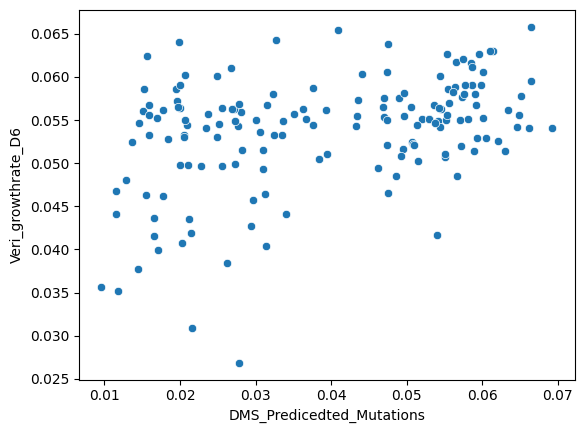

In [31]:
Veri_DMS = sns.scatterplot(x='DMS_Predicedted_Mutations', y='Veri_growthrate_D6', data=ABE_Veri_DFselect_D0.loc[ABE_Veri_DFselect_D0['DMS_Predicedted_Mutations']!='NotFound'])

## Link mutations to sgRNAs

In [32]:
sgVeri = [['BCRABL_1776', 'GCCCAGCTTGTGCTTCATGG'],
['BCRABL_1782', 'GCACAAGCTGGGCGGGGGCC'],
['BCRABL_1792', 'GGCCAGTACGGGGAGGTGTA'],
['BCRABL_1800', 'GGTGTACGAGGGCGTGTGGA'],
['BCRABL_1808', 'AAATACAGCCTGACGGTGGC'],
['BCRABL_1811', 'GGTCTTCACGGCCACCGTCA'],
['BCRABL_1817', 'GGCCGTGAAGACCTTGAAGG'],
['BCRABL_1824', 'CTTGAAGGAGGACACCATGG'],
['BCRABL_1829', 'GGACACCATGGAGGTGGAAG'],
['BCRABL_1831', 'AAGAACTCTTCCACCTCCAT'],
['BCRABL_1833', 'GAGGTGGAAGAGTTCTTGAA'],
['BCRABL_1838', 'AAAGAAGCTGCAGTCATGAA'],
['BCRABL_1840', 'TTGATCTCTTTCATGACTGC'],
['BCRABL_1855', 'GGGTGCAGACCCCAAGGAGC'],
['BCRABL_1861', 'GGTCTGCACCCGGGAGCCCC'],
['BCRABL_1863', 'ATAGAACGGGGGCTCCCGGG'],
['BCRABL_1869', 'CCCGTTCTATATCATCACTG'],
['BCRABL_1873', 'GTAGGTCATGAACTCAGTGA'],
['BCRABL_1874', 'ATCACTGAGTTCATGACCTA'],
['BCRABL_1879', 'ATGACCTACGGGAACCTCCT']]

In [33]:
sgRNA_binding = [] #idenify strandness and binding location of sgRNA

for name, seq in sgVeri:
    sg_strand = 'pos'
    sg_loc = abl.find(seq.lower()) #0-index left most sgrna location
    if sg_loc < 0:
        sg_strand = 'neg'
        sg_loc = abl.find(RevComplment(seq.lower()))
    sgRNA_binding.append([name, seq, sg_strand, sg_loc+1]) #1-indexed location

In [34]:
#determine nucleotides within editing window for each Verification Window
window_start = 2
window_end = 12
sgRNA_Editing_Nucs = []

for name, seq, sg_strand, sg_loc in sgRNA_binding:
    if sg_strand == 'pos':
        sg_window_start = sg_loc + window_start-1
        sg_window_end = sg_loc + window_end-1
    if sg_strand == 'neg':
        sg_window_end = sg_loc + 20 - window_start
        sg_window_start = sg_loc + 20 - window_end
    sg_editing_window = [*range(sg_window_start, sg_window_end)]
    sgRNA_Editing_Nucs.append([name, seq, sg_strand, sg_editing_window])

In [35]:
mismatch_sgRNA_within_window = []
mismatch_sgRNA_relationship = []

for mis in ABE_Veri_DFselect_D0['Mismatch']:
    mismatch_editing_sgRNA = []
    for nuc, edit in ast.literal_eval(mis):
        for name, seq, sg_strand, sg_editing_window in sgRNA_Editing_Nucs:
            if edit == 'C':
                if sg_strand == 'neg':
                    if nuc in sg_editing_window:
                        mismatch_editing_sgRNA.append(name)
            if edit == 'G':
                if sg_strand == 'pos':
                    if nuc in sg_editing_window:
                        mismatch_editing_sgRNA.append(name)
    mismatch_editing_sgRNA = list(set(mismatch_editing_sgRNA))
    if len(mismatch_editing_sgRNA) > 0:
        mismatch_sgRNA_within_window.append(True)
        mismatch_sgRNA_relationship.append(str(mismatch_editing_sgRNA))
    if len(mismatch_editing_sgRNA) == 0:
        mismatch_sgRNA_within_window.append(False)
        mismatch_sgRNA_relationship.append(str(['None']))

In [36]:
ABE_Veri_DFselect_D0['within_editing_window'] = mismatch_sgRNA_within_window
ABE_Veri_DFselect_D0['sgRNA'] = mismatch_sgRNA_relationship

In [37]:
ABE_Veri_DFselect_D0.head()

,Mismatch,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Veri_growthrate_D6,Mutation_Effect,ABE_Activity,mut,DMS_Predicedted_Mutations,Nuc_edit_num,D0,within_editing_window,sgRNA
0,[],278728.845102,-0.880991,0.630458,-1.397382,1.622986e-01,4.868959e-01,0.050759,[],WT,WT,0.055,0,0.869698,False,['None']
1,"[[307, 'T']]",6565.210023,-2.092225,0.727522,-2.875824,4.029741e-03,4.013622e-02,0.044929,"[[gac, Tac, D, 325, Y]]",Other,D325Y,NotFound,1,0.024513,False,['None']
2,"[[77, 'C']]",1296.130809,-4.108802,0.507714,-8.092750,5.833251e-16,7.262397e-14,0.035222,"[[ctg, cCg, L, 248, P]]",A > G,L248P,0.011747,1,0.015735,True,['BCRABL_1776']
3,"[[89, 'G']]",570.579110,-3.451840,0.679618,-5.079089,3.792498e-07,1.573887e-05,0.038384,"[[cag, cGg, Q, 252, R]]",A > G,Q252R,0.026173,1,0.006390,True,['BCRABL_1792']
4,"[[89, 'G'], [92, 'G']]",648.660713,-4.028546,0.784494,-5.135216,2.818198e-07,1.403463e-05,0.035609,"[[cag, cGg, Q, 252, R], [tac, tGc, Y, 253, C]]",A > G,"[Q252R, Y253C]",0.009618,2,0.008098,True,['BCRABL_1792']


In [38]:
ABE_Veri_DFselect_D0.to_csv('Verification_Screen0608.csv')

### Background Mutation Rate Based 95th percentile out of window mismatch frequency 

In [42]:
Background_Freq = np.percentile(ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['within_editing_window']==False) & (ABE_Veri_DFselect_D0['ABE_Activity']=='Other'), 'D0'],95)
Background_Freq

0.0006559475430693052

In [43]:
ABE_Veri_DMS_above_background =ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['D0']>Background_Freq)]

In [44]:
ABE_Veri_DMS_above_background.to_csv('ABE_Veri_DMS_above_background.csv')

In [45]:
ABE_Veri_DMS_above_background =ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['DMS_Predicedted_Mutations']!='NotFound')&
                           (ABE_Veri_DFselect_D0['D0']>Background_Freq)]

In [46]:
ABE_Veri_DMS_above_background

,Mismatch,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Veri_growthrate_D6,Mutation_Effect,ABE_Activity,mut,DMS_Predicedted_Mutations,Nuc_edit_num,D0,within_editing_window,sgRNA
0,[],278728.845102,-0.880991,0.630458,-1.397382,1.622986e-01,4.868959e-01,0.050759,[],WT,WT,0.055,0,0.869698,False,['None']
2,"[[77, 'C']]",1296.130809,-4.108802,0.507714,-8.092750,5.833251e-16,7.262397e-14,0.035222,"[[ctg, cCg, L, 248, P]]",A > G,L248P,0.011747,1,0.015735,True,['BCRABL_1776']
3,"[[89, 'G']]",570.579110,-3.451840,0.679618,-5.079089,3.792498e-07,1.573887e-05,0.038384,"[[cag, cGg, Q, 252, R]]",A > G,Q252R,0.026173,1,0.006390,True,['BCRABL_1792']
4,"[[89, 'G'], [92, 'G']]",648.660713,-4.028546,0.784494,-5.135216,2.818198e-07,1.403463e-05,0.035609,"[[cag, cGg, Q, 252, R], [tac, tGc, Y, 253, C]]",A > G,"[Q252R, Y253C]",0.009618,2,0.008098,True,['BCRABL_1792']
5,"[[143, 'C']]",494.392438,-4.998809,0.561517,-8.902327,5.468787e-19,1.361728e-16,0.030938,"[[gtg, gCg, V, 270, A]]",A > G,V270A,0.021596,1,0.006321,True,['BCRABL_1811']
6,"[[181, 'C']]",435.353554,-2.775917,0.578642,-4.797299,1.608194e-06,5.720574e-05,0.041638,"[[ttc, Ctc, F, 283, L]]",A > G,F283L,0.053971,1,0.004543,True,['BCRABL_1831']
7,"[[155, 'G']]",1036.587831,-0.742337,0.623405,-1.190778,2.337408e-01,6.080721e-01,0.051427,"[[aag, aGg, K, 274, R]]",A > G,K274R,0.058892,1,0.003902,True,['BCRABL_1824']
8,"[[163, 'G'], [166, 'G']]",347.303346,-2.783526,0.604477,-4.604851,4.127611e-06,1.284719e-04,0.041601,"[[acc, Gcc, T, 277, A], [atg, Gtg, M, 278, V]]",A > G,"[T277A, M278V]",0.016543,2,0.003505,True,['BCRABL_1829']
9,"[[154, 'G'], [155, 'G']]",319.739244,-3.130836,0.708165,-4.421057,9.821927e-06,2.223327e-04,0.039930,"[[aag, GGg, K, 274, G]]",A > G,K274G,0.017076,2,0.003327,True,['BCRABL_1824']
10,"[[163, 'G']]",390.858449,-0.436357,0.586623,-0.743844,4.569706e-01,8.201847e-01,0.052900,"[[acc, Gcc, T, 277, A]]",A > G,T277A,0.060509,1,0.001658,True,['BCRABL_1829']


In [47]:
ABE_Veri_sgRNA = pd.read_csv('ABE_Veri_DESeq2.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'ABE_Veri_DESeq2.csv'

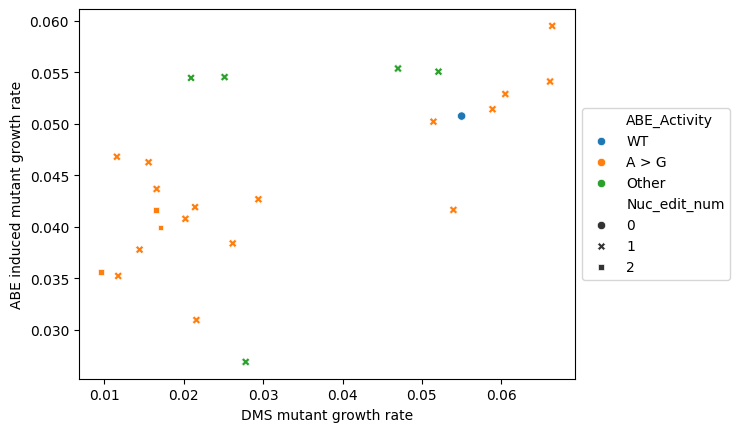

In [48]:
Veri_DMS = sns.scatterplot(x='DMS_Predicedted_Mutations', y='Veri_growthrate_D6',  hue = 'ABE_Activity', style='Nuc_edit_num', data=ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['DMS_Predicedted_Mutations']!='NotFound')&
                           (ABE_Veri_DFselect_D0['D0']>Background_Freq)])
Veri_DMS.set(ylabel='ABE induced mutant growth rate', xlabel='DMS mutant growth rate')
Veri_DMS.legend(loc='center left', bbox_to_anchor=(1, 0.5))
Veri_DMS.get_figure().savefig("Veri mut vs DMS Mut GR0608.png" , bbox_inches='tight', transparent=True) 

In [214]:
ABE_Veri_DMS_above_background.to_csv('ABE_Veri_DF_DMS_pred0608.csv')

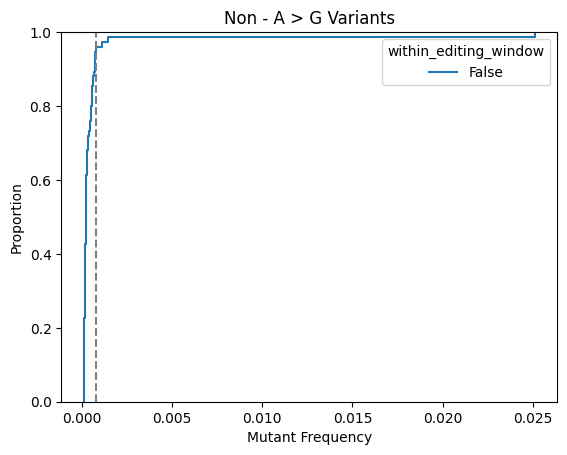

In [215]:
ecdf = sns.ecdfplot(x='D0', hue='within_editing_window',data=ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['ABE_Activity']=='Other')])
ecdf.set(xlabel='Mutant Frequency', title='Non - A > G Variants')
plt.vlines(Background_Freq,0, 1, linestyles="--", color='grey')
ecdf.get_figure().savefig("Background Mutation Cutoff Veri Screen.png")

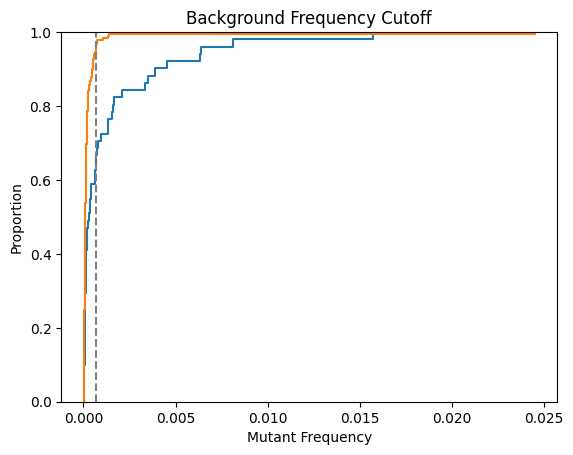

In [52]:
ecdf = sns.ecdfplot(x='D0', data=ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['within_editing_window']==True) & (ABE_Veri_DFselect_D0['ABE_Activity']=='A > G')])
sns.ecdfplot(x='D0',data=ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['within_editing_window']==False) & (ABE_Veri_DFselect_D0['ABE_Activity']=='Other')])
ecdf.set(xlabel='Mutant Frequency', title='Background Frequency Cutoff')
plt.vlines(Background_Freq,0, 1, linestyles="--", color='grey')
ecdf.get_figure().savefig("Background Mutation Cutoff Veri Screen Linear.png")

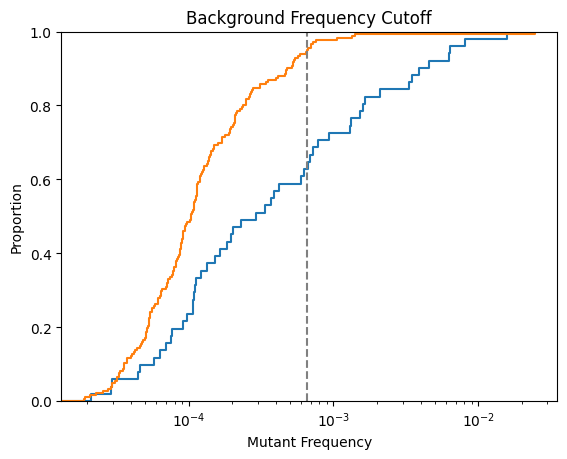

In [53]:
ecdf = sns.ecdfplot(x='D0', data=ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['within_editing_window']==True) & (ABE_Veri_DFselect_D0['ABE_Activity']=='A > G')])
sns.ecdfplot(x='D0',data=ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['within_editing_window']==False) & (ABE_Veri_DFselect_D0['ABE_Activity']=='Other')])
ecdf.set(xlabel='Mutant Frequency', title='Background Frequency Cutoff', xscale='log')
plt.vlines(Background_Freq,0, 1, linestyles="--", color='grey')
ecdf.get_figure().savefig("Background Mutation Cutoff Veri Screen Log.png")

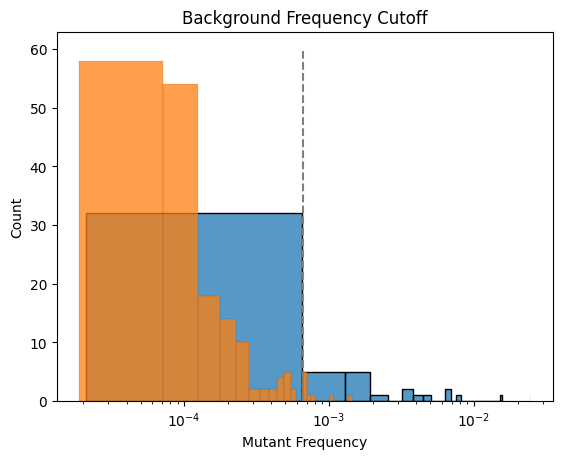

In [57]:
hist = sns.histplot(x='D0', data=ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['within_editing_window']==True) & (ABE_Veri_DFselect_D0['ABE_Activity']=='A > G')])
sns.histplot(x='D0',data=ABE_Veri_DFselect_D0.loc[(ABE_Veri_DFselect_D0['within_editing_window']==False) & (ABE_Veri_DFselect_D0['ABE_Activity']=='Other')])
hist.set(xlabel='Mutant Frequency', title='Background Frequency Cutoff', xscale='log')
plt.vlines(Background_Freq,0, 60, linestyles="--", color='grey')
#hist.get_figure().savefig("Background Mutation Cutoff Veri Screen Hist log.png")

In [60]:
ABE_Veri_DFselect_D0.to_csv('ABE_Veri_DFselect_D0.csv')

In [61]:
ABE_Veri_DFselect_D0

,Mismatch,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Veri_growthrate_D6,Mutation_Effect,ABE_Activity,mut,DMS_Predicedted_Mutations,Nuc_edit_num,D0,within_editing_window,sgRNA
0,[],278728.845102,-0.880991,0.630458,-1.397382,1.622986e-01,4.868959e-01,0.050759,[],WT,WT,0.055,0,0.869698,False,['None']
1,"[[307, 'T']]",6565.210023,-2.092225,0.727522,-2.875824,4.029741e-03,4.013622e-02,0.044929,"[[gac, Tac, D, 325, Y]]",Other,D325Y,NotFound,1,0.024513,False,['None']
2,"[[77, 'C']]",1296.130809,-4.108802,0.507714,-8.092750,5.833251e-16,7.262397e-14,0.035222,"[[ctg, cCg, L, 248, P]]",A > G,L248P,0.011747,1,0.015735,True,['BCRABL_1776']
3,"[[89, 'G']]",570.579110,-3.451840,0.679618,-5.079089,3.792498e-07,1.573887e-05,0.038384,"[[cag, cGg, Q, 252, R]]",A > G,Q252R,0.026173,1,0.006390,True,['BCRABL_1792']
4,"[[89, 'G'], [92, 'G']]",648.660713,-4.028546,0.784494,-5.135216,2.818198e-07,1.403463e-05,0.035609,"[[cag, cGg, Q, 252, R], [tac, tGc, Y, 253, C]]",A > G,"[Q252R, Y253C]",0.009618,2,0.008098,True,['BCRABL_1792']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,"[[176, 'G'], [177, 'G']]",33.333097,2.244573,0.805703,2.785857,5.338642e-03,4.923414e-02,0.065804,"[[gaa, gGG, E, 281, G]]",A > G,E281G,0.066415,2,0.000021,True,['BCRABL_1833']
261,"[[118, 'G']]",7.116842,0.851854,0.830142,1.026155,3.048188e-01,NaN,0.059100,"[[aag, Gag, K, 262, E]]",A > G,K262E,0.058594,1,0.000019,False,['None']
262,"[[173, 'G']]",8.444696,0.033841,0.859358,0.039380,9.685875e-01,NaN,0.055163,"[[gtg, gGg, V, 280, G]]",Other,V280G,0.058068,1,0.000021,True,['BCRABL_1833']
263,"[[130, 'A']]",197.779029,0.843168,1.824934,0.462027,6.440623e-01,9.170761e-01,0.059059,"[[ctg, Atg, L, 266, M]]",Other,L266M,0.057705,1,0.000019,False,['None']


In [62]:
count.T.reset_index().to_csv('Veri_counts.csv')

# Predicting sgRNA GR from detected mutations

In [188]:
sgRNA_edit_eff_growthrates = []
sgRNA_GR_pred_from_DMS = []
for sgRNA in Veri_DMS_ABE['sgRNA_ID'].drop_duplicates():
    sgRNA_Muts = Veri_DMS_ABE.loc[Veri_DMS_ABE['sgRNA_ID']==sgRNA, ['Mismatch','growth_rate_D6', 'D0', 'sgRNA_ID', 'sgRNA_D0_Freq']]
    sgRNA_Freq = sgRNA_Muts['sgRNA_D0_Freq'].drop_duplicates().values[0]
    sgRNA_Edit_Freq = sgRNA_Muts['D0'].sum()
    Unindentied_Freq = sgRNA_Freq - sgRNA_Edit_Freq #WT Freq
    Relative_sgRNA_contributions = [[sgRNA, 'WT', Unindentied_Freq/sgRNA_Freq , 0.055]] #Mismatch, Edit Efficiency, Growth Rate
    if sgRNA_Muts['Mismatch'].isna().values[0] == False: #check if any edits made by this sgRNA
        for mismatch in sgRNA_Muts['Mismatch']:
            Relative_Edit_Freq = sgRNA_Muts.loc[sgRNA_Muts['Mismatch']==mismatch, 'D0'].values[0] / sgRNA_Freq
            Edit_growthrate = sgRNA_Muts.loc[sgRNA_Muts['Mismatch']==mismatch, 'growth_rate_D6'].values[0]
            Relative_sgRNA_contributions.append([sgRNA, mismatch, Relative_Edit_Freq, Edit_growthrate])
    Pred_growth_rate = []
    for sgRNA, mismatch, Relative_Edit_Freq, Edit_growthrate in Relative_sgRNA_contributions:
        Pred_growth_rate.append(Relative_Edit_Freq*Edit_growthrate)
        sgRNA_edit_eff_growthrates.append([sgRNA, mismatch, Relative_Edit_Freq, Edit_growthrate ])
    sgRNA_GR_pred_from_DMS.append([sgRNA, sum(Pred_growth_rate), sgRNA_Edit_Freq/sgRNA_Freq])

In [189]:
Veri_pred_sgRNA_growthrate_DF = pd.DataFrame(sgRNA_GR_pred_from_DMS, columns=['sgRNA_ID', 'Veri_DMS_Pred_growthrate', 'Edit_efficincy'])
Veri_Effi_DF = pd.DataFrame(sgRNA_edit_eff_growthrates, columns=['sgRNA_ID', 'mismatch', 'Relative_Edit_Freq', 'Edit_growthrate'])

In [190]:
Veri_sgRNA_pred_actual_DF = pd.merge(Veri_pred_sgRNA_growthrate_DF, Veri_sgRNA, on='sgRNA_ID')

<Axes: xlabel='sgRNA_growthrate', ylabel='Veri_DMS_Pred_growthrate'>

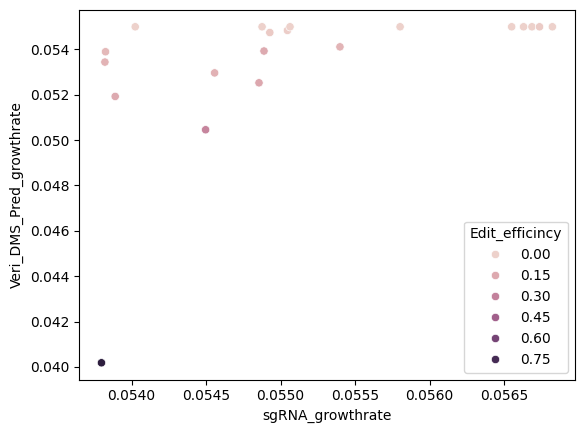

In [191]:
sns.scatterplot(x='sgRNA_growthrate', y='Veri_DMS_Pred_growthrate', hue='Edit_efficincy', data=Veri_sgRNA_pred_actual_DF)

In [192]:
Veri_sgRNA_pred_actual_DF[['Veri_DMS_Pred_growthrate', 'sgRNA_growthrate']].corr('spearman')

,Veri_DMS_Pred_growthrate,sgRNA_growthrate
Veri_DMS_Pred_growthrate,1.000000,0.715443
sgRNA_growthrate,0.715443,1.000000


In [193]:
Veri_D6[['Mismatch', 'mut', 'growth_rate_D6', 'pvalue', 'padj']]

,Mismatch,mut,growth_rate_D6,pvalue,padj
0,[],WT,0.052471,1.930814e-01,3.497481e-01
1,"[[77, 'C']]",L248P,0.037203,1.396532e-22,6.663452e-21
2,"[[307, 'T']]",D325Y,0.047465,4.907497e-03,1.781635e-02
3,"[[89, 'G']]",Q252R,0.039144,4.516842e-58,5.028751e-56
4,"[[181, 'C']]",F283L,0.041440,2.932148e-23,1.958675e-21
...,...,...,...,...,...
329,"[[285, 'A']]",F317L,0.056267,7.285949e-01,8.221307e-01
330,"[[273, 'A']]",I313I,0.056827,6.253263e-01,7.597481e-01
331,"[[267, 'A']]",F311L,0.058061,4.090052e-01,5.813095e-01
332,"[[64, 'G']]",M244V,0.051539,2.930474e-01,4.616878e-01


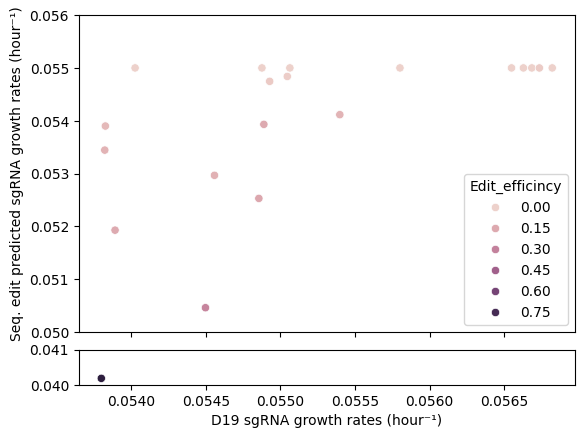

In [195]:
f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios':[0.9,0.1]})
subplot1 = sns.scatterplot(x='sgRNA_growthrate', y='Veri_DMS_Pred_growthrate', hue='Edit_efficincy', data=Veri_sgRNA_pred_actual_DF, ax=ax2, legend=False)
subplot2 = sns.scatterplot(x='sgRNA_growthrate', y='Veri_DMS_Pred_growthrate', hue='Edit_efficincy', data=Veri_sgRNA_pred_actual_DF, ax=ax1)
subplot2.set(ylabel='Seq. edit predicted sgRNA growth rates (hour⁻¹)')
subplot1.set(xlabel='D19 sgRNA growth rates (hour⁻¹)', ylabel=None)
ax1.set_ylim(0.05, 0.056)
ax2.set_ylim(0.040, 0.041)
plt.subplots_adjust(wspace=0, hspace=0.1)
subplot1.get_figure().savefig("Veri v Sequenced Edit Correlation240526.png")